Thank you in advance for considering this code sample as a part of my application for the Data Scientist role at RTI.

This Jupyter Notebook captures an exploratory analysis of the NTSB's database of aviation accidents. Several different analytic methods are applied to derive insights from the provided data assets: https://www.ntsb.gov/_layouts/ntsb.aviation/index.aspx

# Table of Contents
0. Extract and load raw data into pandas
1. Exploration of seasonality and trend in events
2. Latent textual patterns in accident narratives
3. Most commonly used words over time
4. Modeling fatal vs non-fatal accidents

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import xml.etree.ElementTree as ET
import json
import os
import string
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## 0. Extract raw data
Throughout this notebook, data will be postured for individual analyses by referencing an `all_data` dataframe. These cells capture the simple ETL process for getting the XML database and json text into a single pandas dataframe.

In [2]:
# Path to a folder that contains the XML file and all of the narrative JSON files
data_path = 'C:\\Users\\Shreye\\Documents\\data-scientist-exercise02\\data\\'

In [3]:
# Load XML file into dataframe
# https://stackoverflow.com/questions/41795198/more-efficient-conversion-of-xml-file-into-dataframe.
etree = ET.parse(data_path + 'AviationData.xml') 
data = []
for el in etree.iterfind('./*'):
    for i in el.iterfind('*'):
        data.append(dict(i.items()))       
aviation = pd.DataFrame(data)
aviation.shape

(77257, 31)

In [4]:
# Load JSON files into dataframe
narrative = pd.DataFrame()
all_jsons = [file for file in os.listdir(data_path) if file!='AviationData.xml'] # get a list of all of the JSON file names
for json_name in all_jsons:
    with open(data_path+json_name) as json_file: # read each JSON into a dataframe
        json_content = json_file.read()
        json_data = json.loads(json_content)
        json_df = pd.DataFrame(json_data['data']) # the "dataframe" is within the 'data' field of the JSON file
        narrative = pd.concat([narrative, json_df]) # concatenate all of the JSON dataframes
narrative.shape

(76133, 3)

In [5]:
# Merge the dataframes on the common EventId field
all_data = aviation.merge(narrative, how='left')
all_data.shape
all_data.describe()

,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,EventDate,EventId,FARDescription,InjurySeverity,InvestigationType,Latitude,Location,Longitude,Make,Model,NumberOfEngines,PublicationDate,PurposeOfFlight,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition,narrative,probable_cause
count,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257,77257
unique,77257,2814,13,4,9489,22284,3,13,174,15,12180,76133,17,120,2,16343,24702,17471,7204,11029,8,3403,23,67493,4,4,118,63,41,364,4,75557,47435
top,LAX05LA069,,,Substantial,,,No,LANDING,United States,Reciprocating,07/08/2000,20101022X34140,,Non-Fatal,Accident,,"ANCHORAGE, AK",,CESSNA,152,1,,Personal,,Probable Cause,,0,0,0,1,VMC,,
freq,1,73439,60737,55420,33780,29926,69198,18553,73076,63016,25,3,60592,58499,74207,53496,372,53505,16609,2251,61465,13188,43360,2756,72264,65878,40363,40342,42955,22029,68764,231,26754


> From all accidents, the most commmon phase of flight is LANDING and the most common aircraft is a Cessna 152

In [6]:
all_data['TotalFatalInjuries'] = pd.to_numeric(all_data.TotalFatalInjuries, errors='coerce')
all_data['TotalMinorInjuries'] = pd.to_numeric(all_data.TotalMinorInjuries, errors='coerce')
all_data['TotalSeriousInjuries'] = pd.to_numeric(all_data.TotalSeriousInjuries, errors='coerce')
all_data['TotalUninjured'] = pd.to_numeric(all_data.TotalUninjured, errors='coerce')
all_data['passengers'] = all_data.TotalUninjured + all_data.TotalSeriousInjuries + all_data.TotalMinorInjuries + all_data.TotalFatalInjuries
all_data.describe()

,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,passengers
count,55791.000000,54733.000000,53744.000000,65862.000000,49951.000000
mean,0.788962,0.492555,0.309895,5.716817,5.284459
std,6.087442,2.779814,1.368488,29.052413,24.703211
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,2.000000
75%,1.000000,1.000000,0.000000,2.000000,2.000000
max,349.000000,380.000000,111.000000,699.000000,528.000000


> Average number of passengers on flights that have accidents is 5.28, so not typically commercial airliners

# 1. Exploration of seasonality and trend in events
A time series can be obtained by counting the number of events that occur monthly. A time series decomposition can help describe any overarching seasonality or trend in the number of accidents and incidents that occur over the timeframe of analysis. 

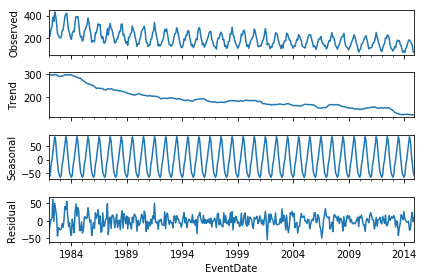

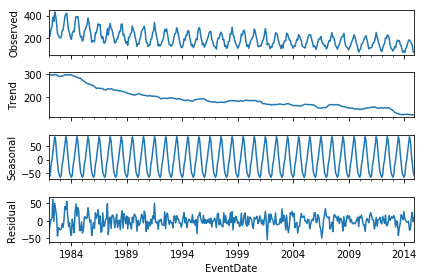

In [7]:
ntsb = all_data.copy()

# set a datetime index of the EventDate to 
ntsb = ntsb[['EventDate', 'AccidentNumber', 'passengers']]
ntsb['EventDate'] = pd.to_datetime(ntsb['EventDate'], format="%m/%d/%Y", errors='coerce')
ntsb.dropna(subset=['EventDate'], inplace=True)
ntsb.index = ntsb['EventDate']

# remove entries before 1982 and after 2014 so we're working with full years of data
ntsb = ntsb[(ntsb.EventDate >= pd.to_datetime('1982-01-01'))&(ntsb.EventDate < pd.to_datetime('2015-01-01'))]

# Aggregate the counts of incidents by month
ntsb_ts = ntsb.resample('M').count()['AccidentNumber']
ntsb_ts.head(24) # summer months appear to have nearly double the incidents as winter months

# Seasonal decomposition as an additive model
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
result = seasonal_decompose(ntsb_ts, model='additive', extrapolate_trend='freq')
result.plot()

In [8]:
# On average, what is the trend over time timeframe of analysis?
(result.trend.min() - result.trend.max())/(2015-1982)

-5.300054743236557

In [9]:
# What is the maximum difference between a season?
result.seasonal.max() - result.seasonal.min()

150.40237014668833

> From 1982-2015 on average there are 5.3 fewer accidents every year, although there are ~150 more accidents in summer than winter

Here we try to visualize the fact that most accidents involve small flights (fewer than 20 passengers, for example)

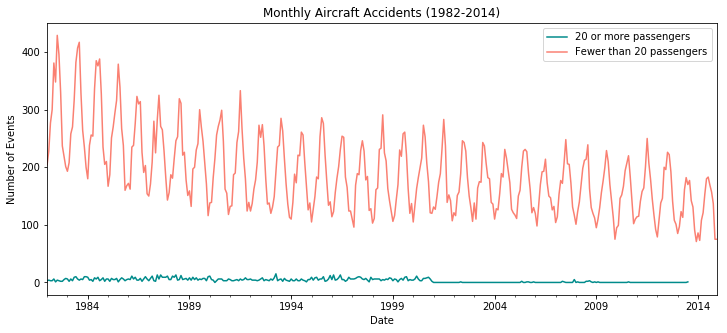

In [10]:
large_flight_size = 20

# Split the dataframe into "large accidents" and "small accidents" based on the defined large flight size
ntsb.passengers.fillna(ntsb.passengers.mean(), inplace=True)
large_accidents = ntsb[ntsb.passengers >= large_flight_size]
small_accidents = ntsb[ntsb.passengers < large_flight_size]

# Obtain a count of incidents by month
large_accidents_ts = large_accidents.resample('M').count()['AccidentNumber']
small_accidents_ts = small_accidents.resample('M').count()['AccidentNumber']

# Plot both on the same figure
plt.figure(figsize=(12,5))

ax1 = large_accidents_ts.plot(color='darkcyan', label='20 or more passengers')
ax2 = small_accidents_ts.plot(color='salmon', label='Fewer than 20 passengers')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.title('Monthly Aircraft Accidents (1982-2014)')
plt.xlabel('Date')
plt.ylabel('Number of Events')

plt.legend(h1, l1, loc='upper right')
plt.show()

# 2. Latent textual patterns in accident narratives
Unsupervised methods of analyzing text can uncover latent patterns in the event narratives. After cleaning the text and removing stopwords, we attempt to extract insight through Latent Semantic Analysis. LSA performs Singular Value Decomposition on the TF-IDF matrix to uncover similarities within the documents and represent them as topics.  https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

LSA is faster and easier to implement than a K-means solution. We do this separately for small and large flights to see what comparisons can be made between resulting topics

In [11]:
ntsb = all_data.copy()

# remove any event that doesnt have a narrative
ntsb = ntsb[['AccidentNumber', 'EventDate', 'narrative', 'passengers']]
ntsb= ntsb[ntsb['narrative'] != '']
ntsb.reset_index(inplace=True, drop=True)
ntsb.shape

(77026, 4)

In [12]:
# Remove punctuation and digits from the text and convert to all lowercase
ntsb.narrative = ntsb.narrative.apply(lambda x: x.lower())
ntsb.narrative = ntsb.narrative.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
ntsb.narrative = ntsb.narrative.apply(lambda x: x.translate(str.maketrans('','',string.digits)))

In [13]:
# get english stop words (plus a few commonly expected words)
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('federal')
stopwords.append('aviation')
stopwords.append('administration')
stopwords.append('foreign')
stopwords.append('authority')
stopwords.append('information')

# remove stopwords from the narratives
tokenized_doc = ntsb['narrative'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords])
detokenized_doc = []
for i in range(len(ntsb)):
    text = ' '.join(tokenized_doc[i])
    detokenized_doc.append(text)
ntsb['narrative'] = detokenized_doc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shreye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
large_flight_size = 20

# split dataset into "large flights" and "small flights", imputing the average for missing values
ntsb['passengers'].fillna(ntsb.passengers.mean(), inplace=True)

large_flights = ntsb[ntsb.passengers >= large_flight_size]
print(large_flights.shape)

small_flights = ntsb[ntsb.passengers < large_flight_size]
print(small_flights.shape)

(1322, 4)
(75704, 4)


First get LSA topics for large flights...

In [15]:
# obtain the Tfidf matrix 
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=.5, smooth_idf=True)
tf_idf = vectorizer.fit_transform(large_flights.narrative)
terms = vectorizer.get_feature_names()

In [16]:
# perform SVD to identify term similarities between documents
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100) # results in top 10 topics
svd_model.fit(tf_idf)


for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    print([t[0] for t in sorted_terms])

Topic 0: 
['flight', 'airplane', 'turbulence', 'engine', 'landing', 'crew', 'runway']
Topic 1: 
['flight', 'turbulence', 'encountered', 'seat', 'attendant', 'attendants', 'belt']
Topic 2: 
['flt', 'rwy', 'acft', 'ctlr', 'apch', 'ft', 'fl']
Topic 3: 
['source', 'runway', 'international', 'flight', 'time', 'approach', 'airport']
Topic 4: 
['source', 'engine', 'turbine', 'flt', 'fuel', 'stage', 'failure']
Topic 5: 
['gear', 'source', 'landing', 'main', 'nose', 'turbulence', 'seat']
Topic 6: 
['flight', 'international', 'gear', 'airport', 'flt', 'plan', 'time']
Topic 7: 
['tug', 'door', 'gate', 'wing', 'ground', 'flt', 'driver']
Topic 8: 
['rwy', 'acft', 'eng', 'apch', 'passengers', 'flight', 'passenger']
Topic 9: 
['door', 'smoke', 'apu', 'evacuation', 'emergency', 'airplane', 'control']


> Large flight narratives emphasize turbulence, mechanical components, and landing issues

In [17]:
# obtain the Tfidf matrix 
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=.5, smooth_idf=True)
tf_idf = vectorizer.fit_transform(small_flights.narrative)
terms = vectorizer.get_feature_names()

In [18]:
# perform SVD to identify term similarities between documents
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100)
svd_model.fit(tf_idf)


for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    print([t[0] for t in sorted_terms])

Topic 0: 
['airplane', 'runway', 'engine', 'fuel', 'left', 'flight', 'right']
Topic 1: 
['fuel', 'acft', 'plt', 'engine', 'tank', 'eng', 'rwy']
Topic 2: 
['acft', 'plt', 'rwy', 'ft', 'flt', 'gear', 'wind']
Topic 3: 
['flight', 'helicopter', 'source', 'time', 'conditions', 'informationon', 'injured']
Topic 4: 
['helicopter', 'rotor', 'engine', 'tail', 'gear', 'main', 'power']
Topic 5: 
['fuel', 'source', 'helicopter', 'gear', 'flight', 'informationon', 'tank']
Topic 6: 
['gear', 'engine', 'source', 'power', 'oil', 'nose', 'collapsed']
Topic 7: 
['gear', 'main', 'obtained', 'work', 'significant', 'investigative', 'conducted']
Topic 8: 
['airplane', 'entities', 'andor', 'operator', 'limited', 'including', 'damage']
Topic 9: 
['student', 'instructor', 'flight', 'gear', 'cfi', 'nose', 'approach']


> Small flight narratives emphasize fuel, helicopters, and instructional flights

Here we repeat the same text analysis methods as above except on the probable_cause field

In [19]:
ntsb = all_data.copy()

# remove any event that doesnt have a narrative
ntsb = ntsb[['AccidentNumber', 'EventDate', 'probable_cause', 'passengers']]
ntsb= ntsb[ntsb['probable_cause'] != '']
ntsb.reset_index(inplace=True, drop=True)
ntsb.shape

(50503, 4)

In [20]:
# Remove parentheses and digits from the text and convert to all lowercase
ntsb.probable_cause = ntsb.probable_cause.apply(lambda x: x.lower())
ntsb.probable_cause = ntsb.probable_cause.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
ntsb.probable_cause = ntsb.probable_cause.apply(lambda x: x.translate(str.maketrans('','',string.digits)))

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('federal')
stopwords.append('aviation')
stopwords.append('administration')
stopwords.append('foreign')
stopwords.append('authority')
stopwords.append('information')

# remove stopwords from the text
tokenized_doc = ntsb['probable_cause'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stopwords])
detokenized_doc = []
for i in range(len(ntsb)):
    text = ' '.join(tokenized_doc[i])
    detokenized_doc.append(text)
ntsb['probable_cause'] = detokenized_doc

In [22]:
# split dataset into "large flights" and "small flights", imputing the average for missing values
large_flight_size = 20
ntsb['passengers'].fillna(ntsb.passengers.mean(), inplace=True)

large_flights = ntsb[ntsb.passengers >= large_flight_size]
print(large_flights.shape)

small_flights = ntsb[ntsb.passengers < large_flight_size]
print(small_flights.shape)

(767, 4)
(49736, 4)


In [23]:
# obtain the Tfidf matrix for the top 1000 terms
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=.5, smooth_idf=True)
tf_idf = vectorizer.fit_transform(large_flights.probable_cause)
terms = vectorizer.get_feature_names()

# identify similar documents through SVD
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100) 
svd_model.fit(tf_idf)

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    print([t[0] for t in sorted_terms])

Topic 0: 
['turbulence', 'encounter', 'clear', 'air', 'flight', 'inflight', 'factor']
Topic 1: 
['turbulence', 'encounter', 'clear', 'air', 'inflight', 'unforecast', 'unexpected']
Topic 2: 
['gear', 'landing', 'main', 'maintenance', 'fatigue', 'right', 'wheel']
Topic 3: 
['clear', 'air', 'controller', 'local', 'clearance', 'controllers', 'aircraft']
Topic 4: 
['maintenance', 'personnel', 'inadequate', 'company', 'inspection', 'engine', 'operator']
Topic 5: 
['inflight', 'encounter', 'maintenance', 'personnel', 'company', 'clearance', 'inadequate']
Topic 6: 
['inflight', 'engine', 'encounter', 'turbine', 'pressure', 'controller', 'high']
Topic 7: 
['improper', 'control', 'elevator', 'runway', 'pilots', 'use', 'factors']
Topic 8: 
['controller', 'flight', 'local', 'separation', 'maintenance', 'improper', 'controllers']
Topic 9: 
['improper', 'evacuation', 'use', 'captain', 'clearance', 'undetermined', 'reasons']


> Large flight probable causes emphasize turbulence, inadequate, and personnel

In [24]:
# obtain the Tfidf matrix for the top 1000 terms
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=.5, smooth_idf=True)
tf_idf = vectorizer.fit_transform(small_flights.probable_cause)
terms = vectorizer.get_feature_names()

# identify similar documents through SVD
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100)
svd_model.fit(tf_idf)

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    print([t[0] for t in sorted_terms])

Topic 0: 
['landing', 'control', 'maintain', 'loss', 'engine', 'power', 'directional']
Topic 1: 
['engine', 'power', 'undetermined', 'reasons', 'loss', 'fuel', 'forced']
Topic 2: 
['undetermined', 'reasons', 'control', 'directional', 'maintain', 'loss', 'roll']
Topic 3: 
['landing', 'flare', 'improper', 'bounced', 'gear', 'hard', 'recovery']
Topic 4: 
['fuel', 'directional', 'control', 'exhaustion', 'maintain', 'starvation', 'roll']
Topic 5: 
['conditions', 'wind', 'compensation', 'crosswind', 'inadequate', 'gusty', 'factor']
Topic 6: 
['terrain', 'forced', 'suitable', 'lack', 'unsuitable', 'landing', 'factor']
Topic 7: 
['wind', 'airspeed', 'compensation', 'stall', 'crosswind', 'factor', 'inadvertent']
Topic 8: 
['carburetor', 'engine', 'loss', 'power', 'improper', 'icing', 'heat']
Topic 9: 
['takeoff', 'runway', 'airplane', 'gear', 'resulted', 'collision', 'roll']


> Small flight probable causes emphasize control, power, and terrain

# 4. Most commonly used words over time
In the NTSB narratives, word usage may change over time. These cells capture attempts to visualize changes in the most popular words by year.

In [25]:
ntsb = all_data.copy()
ntsb = ntsb[['EventDate','narrative','probable_cause']]

# set a datetime index, and drop entries without an EventDate
ntsb['EventDate'] = pd.to_datetime(ntsb['EventDate'], format="%m/%d/%Y", errors='coerce')
ntsb.dropna(subset=['EventDate'], inplace=True)
ntsb.index = ntsb['EventDate']

# Remove punctuation and digits from the narratives
ntsb.narrative = ntsb.narrative.apply(lambda x: x.lower())
ntsb.narrative = ntsb.narrative.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
ntsb.narrative = ntsb.narrative.apply(lambda x: x.translate(str.maketrans('','',string.digits)))

ntsb.head()

,EventDate,narrative,probable_cause
EventDate,,,
2015-09-01,2015-09-01,,
2015-08-31,2015-08-31,on august about central daylight time a ces...,
2015-08-30,2015-08-30,,
2015-08-30,2015-08-30,,
2015-08-29,2015-08-29,,


In [26]:
# Identify frequency of words that aren't stopwords
nltk.download('punkt')
txt = ntsb.narrative.str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
stopwords = nltk.corpus.stopwords.words('english')
word_dist = nltk.FreqDist(w for w in words if w not in stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shreye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# Concatenate all of the narratives within a year before counting words -- this takes some time!
ntsb['year'] = ntsb.EventDate.dt.year
ntsb['annual_narratives'] = ntsb.groupby(ntsb.EventDate.dt.year)['narrative'].transform(lambda x: ' '.join(x)) # concatenate all the narratives from a year into a single cell
ntsb_annual = ntsb[['year', 'annual_narratives']].drop_duplicates() # get a unique list of narratives by year

# Focus analysis on complete year data from 1982 - 2014
ntsb_annual = ntsb_annual[(ntsb_annual.index >= pd.to_datetime('1982-01-01'))&(ntsb_annual.index < pd.to_datetime('2015-01-01'))]
ntsb_annual.reset_index(inplace=True, drop=True)
ntsb_annual.shape

(33, 2)

In [28]:
# The most common words can be plotted over time
most_common_words = pd.DataFrame(word_dist.most_common(10))[0] 
most_common_words

0            pilot
1         airplane
2         aircraft
3         accident
4    investigation
5             data
6             used
7             ntsb
8          support
9          various
Name: 0, dtype: object

In [29]:
# count the occurances of common stopwords by year
for i in range(len(ntsb_annual)):
    for word in most_common_words:
        ntsb_annual.at[i, word] = ntsb_annual.iloc[i]['annual_narratives'].count(word)

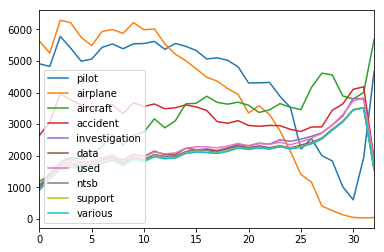

In [30]:
ntsb_annual[most_common_words].plot()

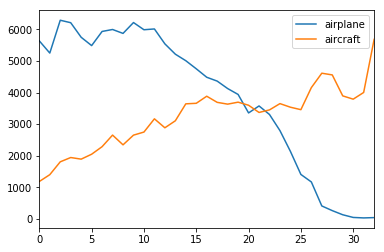

In [31]:
ntsb_annual[most_common_words[1:3]].plot() # pulling out words that show an interesting pattern

# 5. Modeling fatal vs non-fatal accidents
A logistic regression model can help explain factors that influence fatal aircraft accidents. To prepare for a regression analysis, the raw data needs to be cleaned to extract quantiative features. This is done manually for columns of interest: 
* Number of engines (numeric)
* Day of week (weekend/weekday)
* Weather condition (IMC/non-IMC) -- instrumental meteorological conditions implies poor visibility
* Purpose of flight (Personal/non-personal)
* Broad phase of flight (Landing/Takeoff/Standing/Cruising/reference) -- reference level is maneuvering, go-arounds, and unknowns

In [32]:
ntsb = all_data.copy()

In [33]:
ntsb['date'] = pd.to_datetime(ntsb['EventDate'], format="%m/%d/%Y", errors='coerce')

In [34]:
# Remove parentheses and digits from the InjurySeverity column to get a single level for "Fatal" incidents
ntsb.InjurySeverity = ntsb.InjurySeverity.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
ntsb.InjurySeverity = ntsb.InjurySeverity.apply(lambda x: x.translate(str.maketrans('','',string.digits)))

In [35]:
ntsb['engines'] = pd.to_numeric(ntsb['NumberOfEngines'], errors='coerce')
ntsb['engines'].fillna(ntsb.engines.mean(), inplace=True)

In [36]:
def fatal(data):
    if data['InjurySeverity'] == 'Fatal':
        return 1
    else:
        return 0

In [37]:
def weekend(data):
    if data['date'].weekday() < 5:
        return 0
    else:
        return 1

In [38]:
def imc(data):
    if data['WeatherCondition'] == 'IMC':
        return 1
    else:
        return 0

In [39]:
def personal(data):
    if data['PurposeOfFlight'] == 'Personal':
        return 1
    else:
        return 0

In [40]:
all_data.BroadPhaseOfFlight.unique()

array(['', 'LANDING', 'STANDING', 'TAKEOFF', 'APPROACH', 'GO-AROUND',
       'MANEUVERING', 'UNKNOWN', 'CRUISE', 'CLIMB', 'DESCENT', 'OTHER',
       'TAXI'], dtype=object)

In [41]:
def landing(data):
    if data['BroadPhaseOfFlight'] == 'LANDING':
        return 1
    elif data['BroadPhaseOfFlight'] == 'APPROACH':
        return 1
    elif data['BroadPhaseOfFlight'] == 'DESCENT':
        return 1
    else:
        return 0

def takeoff(data):
    if data['BroadPhaseOfFlight'] == 'TAKEOFF':
        return 1
    elif data['BroadPhaseOfFlight'] == 'CLIMB':
        return 1
    elif data['BroadPhaseOfFlight'] == 'TAXI':
        return 1
    else:
        return 0

def standing(data):
    if data['BroadPhaseOfFlight'] == 'STANDING':
        return 1
    else:
        return 0
    
def cruising(data):
    if data['BroadPhaseOfFlight'] == 'CRUISE':
        return 1
    else:
        return 0

In [42]:
ntsb['fatal'] = ntsb.apply(fatal, axis=1)
ntsb['weekend'] = ntsb.apply(weekend, axis=1)
ntsb['imc'] = ntsb.apply(imc, axis=1)
ntsb['landing'] = ntsb.apply(landing, axis=1)
ntsb['takeoff'] = ntsb.apply(takeoff, axis=1)
ntsb['standing'] = ntsb.apply(standing, axis=1)
ntsb['cruising'] = ntsb.apply(cruising, axis=1)
ntsb['personal'] = ntsb.apply(personal, axis=1)

ntsb_reg = ntsb[['fatal', 'engines', 'personal', 'weekend', 'imc', 'landing', 'takeoff', 'standing', 'cruising']]
ntsb_reg.describe()

,fatal,engines,personal,weekend,imc,landing,takeoff,standing,cruising
count,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000,77257.000000
mean,0.199451,1.149095,0.561244,0.364122,0.072226,0.365210,0.248845,0.015054,0.137166
std,0.399590,0.451313,0.496238,0.481186,0.258864,0.481492,0.432346,0.121767,0.344024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
train_cols = ntsb_reg.columns[1:]

logit = sm.Logit(ntsb_reg['fatal'], ntsb_reg[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.436682
         Iterations 6


In [44]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  fatal   No. Observations:                77257
Model:                          Logit   Df Residuals:                    77249
Method:                           MLE   Df Model:                            7
Date:                Wed, 15 May 2019   Pseudo R-squ.:                  0.1260
Time:                        14:44:38   Log-Likelihood:                -33737.
converged:                       True   LL-Null:                       -38601.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
engines       -0.4291      0.014    -31.193      0.000      -0.456      -0.402
personal       0.2255      0.019     11.770      0.000       0.188       0.263
weekend       -0.1107      0.020     -5.459      0.000      -0.150      -0.071
imc            2.1052      0.032     64.780      0.000       2.042       2.169
landing       -2.1019      0.026    -79.890      0.000      -2.153      -2.050
takeoff       -1.4890      0.026    -57.315      0.000      -1.540      -1.438
standing      -1.7809      0.100    -17.895      0.000      -1.976      -1.586
cruising      -1.0158      0.029    -35.344      0.000      -1.072      -0.960
==============================================================================
"""

In [45]:
np.exp(result.params) # odds ratios

engines     0.651074
personal    1.252993
weekend     0.895194
imc         8.209146
landing     0.122227
takeoff     0.225606
standing    0.168493
cruising    0.362098
dtype: float64

> The odds of a fatal accident are are 8.21 greater in IMC weather conditions than VMC or unknown weather

In [46]:
1/np.exp(result.params) # inverse odds ratios

engines     1.535923
personal    0.798089
weekend     1.117077
imc         0.121815
landing     8.181512
takeoff     4.432498
standing    5.934960
cruising    2.761681
dtype: float64

> The odds of landings being fatal are 8.18 less than if an aircraft is maneuvering, in a go-around, or unknown phase of flight

Further investigation is needed before reporting regression results -- takeoff and landing should theoretically be the most dangerous phases of flight, although is is reasonable that they are not as fatal as accidents that occur when a plane is maneuvering or when phase of flight is unknown. 